<a href="https://colab.research.google.com/github/ristaardy/econ8030_growthdetective/blob/main/group_project_1_growth_detective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data Collection and Preparation

3 Countries Selected:
1. Indonesia (IDN)
2. Nepal (NPL)
3. United States (USA)

Variables Gathered:
1. `NY_GDP_PCAP_CD` --> GDP per capita (current US$)
2. `SP_POP_TOTL` --> Population, total
3. `SH_MED_BEDS_ZS` --> Hospital beds (per 1,000 people)
4. `EG_ELC_ACCS_ZS` --> Access to electricity (% of population)
5. `SE_PRM_TENR` --> Adjusted net enrollment rate, primary (% of primary school age children)

## 1.1 Library Imports and Data Preparation

In [1]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/1qqNPGa8h22rh0aamRKSlqtKJsf3oiP3Pg_3SeAPn_2A/edit?gid=1308911034#gid=1308911034"    # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df = pd.read_csv(csv_export_url)                                                                                                        # Load the data into a DataFrame
df.head()

,No,Country_Name,Country_Code,Year,NY_GDP_PCAP_CD,SP_POP_TOTL,SH_MED_BEDS_ZS,EG_ELC_ACCS_ZS,SE_PRM_TENR
0,1,Indonesia,IDN,1996,1118.9210,203000000,0.64,72.39,92.51603
1,2,Indonesia,IDN,1997,1044.6070,207000000,0.62,80.30,92.46189
2,3,Indonesia,IDN,1998,454.8778,210000000,0.60,80.94,93.16340
3,4,Indonesia,IDN,1999,657.2689,213000000,0.60,83.73,94.49700
4,5,Indonesia,IDN,2000,763.7111,216000000,0.59,86.30,95.23610


## 1.2 Missing Data Check

In [3]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No              69 non-null     int64  
 1   Country_Name    69 non-null     object 
 2   Country_Code    69 non-null     object 
 3   Year            69 non-null     int64  
 4   NY_GDP_PCAP_CD  69 non-null     float64
 5   SP_POP_TOTL     69 non-null     int64  
 6   SH_MED_BEDS_ZS  69 non-null     float64
 7   EG_ELC_ACCS_ZS  69 non-null     float64
 8   SE_PRM_TENR     55 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 5.0+ KB


In [4]:
# Identify which variables and countries have missing data

# List of variables to check
vars_to_check = ['NY_GDP_PCAP_CD', 'SP_POP_TOTL', 'SH_MED_BEDS_ZS', 'EG_ELC_ACCS_ZS', 'SE_PRM_TENR']

# Create a summary table / pivot of NaN counts per Country_Code
nan_counts = df.groupby('Country_Code')[vars_to_check].apply(lambda x: x.isna().sum())

# Display the result
nan_counts

,NY_GDP_PCAP_CD,SP_POP_TOTL,SH_MED_BEDS_ZS,EG_ELC_ACCS_ZS,SE_PRM_TENR
Country_Code,,,,,
IDN,0,0,0,0,0
NPL,0,0,0,0,0
USA,0,0,0,0,14


The SE_PRM_TENR data is incomplete for the USA, with several missing years.

In [5]:
# Filter data for USA
df_usa = df[df['Country_Code'] == 'USA']

# Create pivot table: rows = Year, columns = Country_Code, values = SE_PRM_TENR
pivot_usa = df_usa.pivot(index='Year', columns='Country_Code', values='SE_PRM_TENR')

# Display the pivot table
print(pivot_usa)


Country_Code       USA
Year                  
1996               NaN
1997               NaN
1998               NaN
1999               NaN
2000               NaN
2001               NaN
2002               NaN
2003               NaN
2004               NaN
2005          99.43481
2006               NaN
2007               NaN
2008               NaN
2009               NaN
2010          97.63436
2011          96.38975
2012          97.26517
2013          97.50924
2014          97.97434
2015          94.60023
2016          99.64003
2017          95.55776
2018               NaN


## 1.3 Data Interpolation

The SE_PRM_TENR data is incomplete for the USA, with several missing years. We attempted interpolation by filling the 2018 value with the average from 2010–2017, while the years 2006, 2007, 2008, and 2009 were estimated using polynomial interpolation. Missing data before 2005 was left blank because there did not appear to be enough data for interpolation.

In [6]:
# Create a mask for USA
mask_usa = df['Country_Code'] == 'USA'

# Create a mask for USA
df_usa = df.loc[mask_usa].copy()

# Calculate the average for 2010-2017 (only for rows with available data)
mask_avg = (df_usa['Year'] >= 2010) & (df_usa['Year'] <= 2017)
mean_2010_2017 = df_usa.loc[mask_avg, 'SE_PRM_TENR'].mean()

# Fill the year 2018 with the average
mask_2018 = df_usa['Year'] == 2018
df_usa.loc[mask_2018, 'SE_PRM_TENR'] = mean_2010_2017

# Perform spline interpolation for the remaining NaN values (outside 2010-2017)
mask_remaining = df_usa['SE_PRM_TENR'].isna()
df_usa.loc[mask_remaining, 'SE_PRM_TENR'] = df_usa['SE_PRM_TENR'].interpolate(
    method='spline',
    order=2
)

# Save the results back to the main DataFrame
df.loc[mask_usa, 'SE_PRM_TENR'] = df_usa['SE_PRM_TENR']

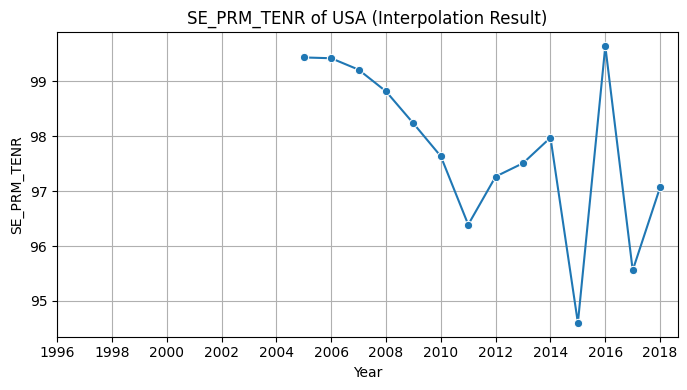

In [7]:
# After Interpolation (USA - SE_PRM_TENR)
plt.figure(figsize=(7,4))

# Plot line with markers
sns.lineplot(
    data=df[df['Country_Code']=='USA'],  # filter directly on plot
    x='Year',
    y='SE_PRM_TENR',
    marker='o'
)

# Set title and y-axis label
plt.title('SE_PRM_TENR of USA (Interpolation Result)')
plt.ylabel('SE_PRM_TENR')

# Set x-axis range and ticks every 2 years
plt.xticks(range(1996, 2019, 2))  # 1996, 1998, ..., 2018

# Show grid
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [8]:
# Filter untuk USA
df_usa = df[df['Country_Code'] == 'USA']

# Pilih kolom yang ingin ditampilkan, misal Year + SE_PRM_TENR
df_usa_table = df_usa[['Year', 'SE_PRM_TENR']]

# Tampilkan tabel
print(df_usa_table.to_string(index=False))

 Year  SE_PRM_TENR
 1996          NaN
 1997          NaN
 1998          NaN
 1999          NaN
 2000          NaN
 2001          NaN
 2002          NaN
 2003          NaN
 2004          NaN
 2005    99.434810
 2006    99.419993
 2007    99.212353
 2008    98.816881
 2009    98.233577
 2010    97.634360
 2011    96.389750
 2012    97.265170
 2013    97.509240
 2014    97.974340
 2015    94.600230
 2016    99.640030
 2017    95.557760
 2018    97.071360


## 1.4 Plotting All Variables

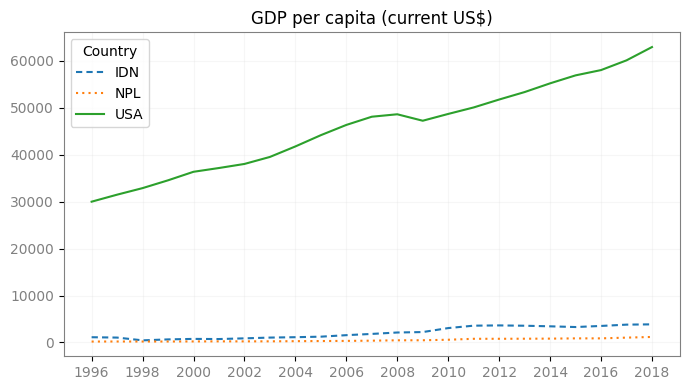

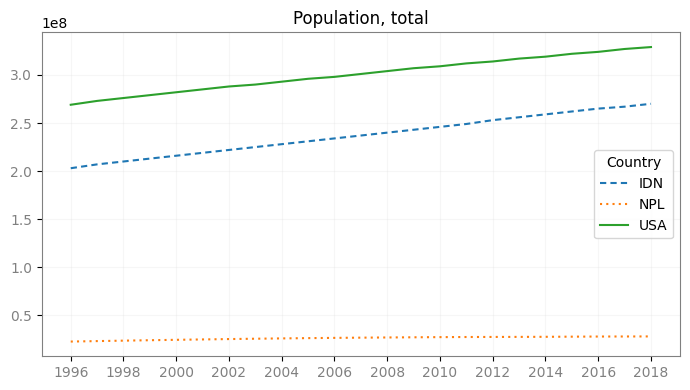

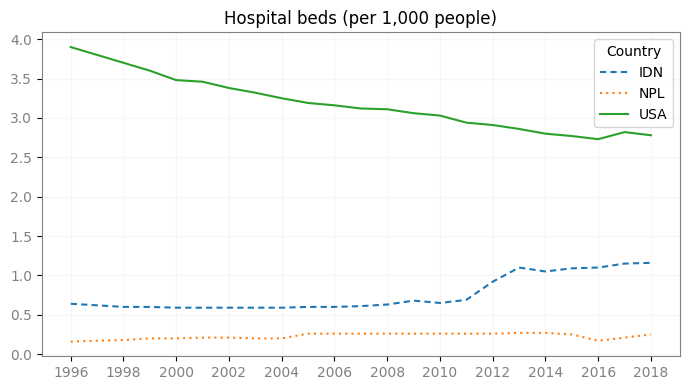

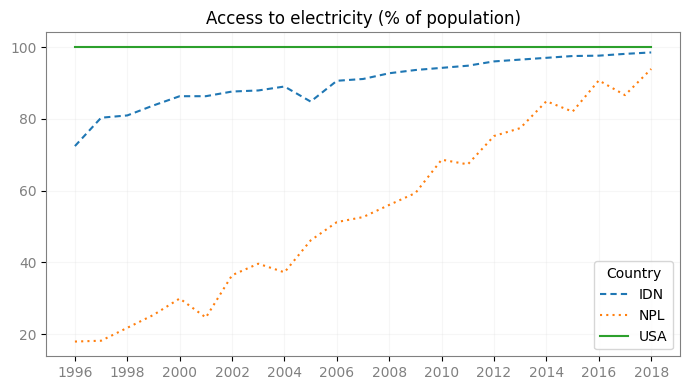

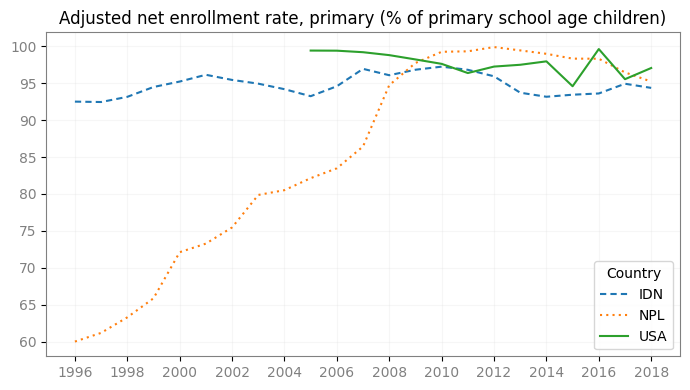

In [9]:
# List of variables
variables = ['NY_GDP_PCAP_CD', 'SP_POP_TOTL', 'SH_MED_BEDS_ZS', 'EG_ELC_ACCS_ZS', 'SE_PRM_TENR']

# Mapping variable codes and its descriptions
var_desc = {
    'NY_GDP_PCAP_CD': 'GDP per capita (current US$)',
    'SP_POP_TOTL': 'Population, total',
    'SH_MED_BEDS_ZS': 'Hospital beds (per 1,000 people)',
    'EG_ELC_ACCS_ZS': 'Access to electricity (% of population)',
    'SE_PRM_TENR': 'Adjusted net enrollment rate, primary (% of primary school age children)'
}

# 1996, 1998, ..., 2018
years_ticks = list(range(1996, 2019, 2))

# Mapping dash style per country
dash_styles = {
    'USA': '',   # line
    'IDN': (3, 2),   # dash
    'NPL': (1, 2)    # dot
}

# Loop each variabel → Create separated graphs
for var in variables:
    plt.figure(figsize=(7, 4))  # figure baru tiap variabel

    # Line plot
    sns.lineplot(
        data=df,
        x='Year',
        y=var,
        hue='Country_Code',
        style='Country_Code',
        dashes=dash_styles,
        # palette=['black'] * 3
    )

    # Costumize grid, ticks, spines
    plt.grid(True, color='lightgray', linewidth=0.8, alpha=0.2)
    plt.xticks(years_ticks, color='gray')
    plt.yticks(color='gray')

    ax = plt.gca()
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')

    plt.title(var_desc[var])
    plt.xlabel('')  # Remove X label
    plt.ylabel('')  # Remove Y label
    plt.legend(title='Country', loc='best')

    plt.tight_layout()
    plt.show()   # Show one by one
    print()


# Part 2: Comparing Growth Across Countries

In this section, we compare the growth rates of Indonesia, Nepal, and the United States. We begin by calculating annual growth rates (since the previously entered data referred to GDP), followed by the average growth rates for each period, and finally the average growth rate for the entire period. Graphs were then created to illustrate both annual growth and period-based growth.

## 2.1 Calculate Growth Rates

### 2.1.1 Growth Rates per Year

In [10]:
# Sort data just in case
df = df.sort_values(by=['Country_Code', 'Year'])

# Create new column for GDP per capita growth rate
df['GDP_PCAP_GROWTH'] = df.groupby('Country_Code')['NY_GDP_PCAP_CD'].pct_change() * 100

# Check result for first few rows
df[['Country_Code', 'Year', 'NY_GDP_PCAP_CD', 'GDP_PCAP_GROWTH']].head()

,Country_Code,Year,NY_GDP_PCAP_CD,GDP_PCAP_GROWTH
0,IDN,1996,1118.9210,NaN
1,IDN,1997,1044.6070,-6.641577
2,IDN,1998,454.8778,-56.454648
3,IDN,1999,657.2689,44.493510
4,IDN,2000,763.7111,16.194620


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               69 non-null     int64  
 1   Country_Name     69 non-null     object 
 2   Country_Code     69 non-null     object 
 3   Year             69 non-null     int64  
 4   NY_GDP_PCAP_CD   69 non-null     float64
 5   SP_POP_TOTL      69 non-null     int64  
 6   SH_MED_BEDS_ZS   69 non-null     float64
 7   EG_ELC_ACCS_ZS   69 non-null     float64
 8   SE_PRM_TENR      60 non-null     float64
 9   GDP_PCAP_GROWTH  66 non-null     float64
dtypes: float64(5), int64(3), object(2)
memory usage: 5.5+ KB


### 2.1.2 Growth Rates per Period

In this section, we calculate the average growth rates by dividing the data into several periods:
- 1996–1999,
- 2000–2003,
- 2004–2007,
- 2008–2011,
- 2012–2015,
- 2016–2018.

In [12]:
# Make sure the growth column already exists; Already run in the previous code
# df['GDP_PCAP_GROWTH'] = df.groupby('Country_Code')['NY_GDP_PCAP_CD'].pct_change() * 100

# Define 4-year periods
def assign_period(year):
    if 1996 <= year <= 1999:
        return '1996-1999'
    elif 2000 <= year <= 2003:
        return '2000-2003'
    elif 2004 <= year <= 2007:
        return '2004-2007'
    elif 2008 <= year <= 2011:
        return '2008-2011'
    elif 2012 <= year <= 2015:
        return '2012-2015'
    elif 2016 <= year <= 2018:
        return '2016-2018'
    else:
        return None

# Create the period column
df['Period_4yr'] = df['Year'].apply(assign_period)

# Calculate the average growth by Country_Code and period
avg_growth_4yr = df.groupby(['Country_Code', 'Period_4yr'])['GDP_PCAP_GROWTH'].mean().reset_index()

# Display the results
print(avg_growth_4yr)


   Country_Code Period_4yr  GDP_PCAP_GROWTH
0           IDN  1996-1999        -6.200905
1           IDN  2000-2003        12.699866
2           IDN  2004-2007        15.187883
3           IDN  2008-2011        18.974006
4           IDN  2012-2015        -2.073538
5           IDN  2016-2018         5.535032
6           NPL  1996-1999         1.698529
7           NPL  2000-2003         4.305360
8           NPL  2004-2007        11.842792
9           NPL  2008-2011        20.074492
10          NPL  2012-2015         2.775411
11          NPL  2016-2018        10.702174
12          USA  1996-1999         4.822511
13          USA  2000-2003         3.431125
14          USA  2004-2007         5.030050
15          USA  2008-2011         1.039937
16          USA  2012-2015         3.248975
17          USA  2016-2018         3.421499


### 2.1.3 Growth Rates whole Period

In [13]:
# Calculate average GDP per capita growth for each country across the whole period
avg_growth = (
    df.groupby('Country_Code')['GDP_PCAP_GROWTH']
      .mean()
      .reset_index()
      .rename(columns={'GDP_PCAP_GROWTH': 'Avg_GDP_PCAP_GROWTH'})
)

avg_growth


,Country_Code,Avg_GDP_PCAP_GROWTH
0,IDN,8.052511
1,NPL,8.781561
2,USA,3.442381


## 2.2 Visualize Growth

### 2.2.1 Growth Rates per Year

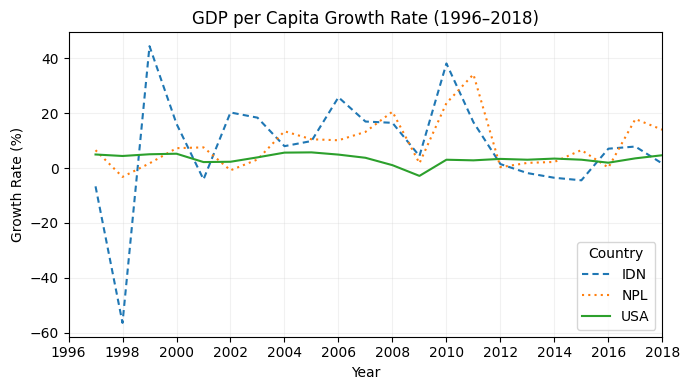

In [14]:
# Mapping dash style per country
dash_styles = {
    'USA': (None, None),   # line
    'IDN': (3, 2),   # dash
    'NPL': (1, 2)    # dot
}

# Plot GDP per capita growth
plt.figure(figsize=(7,4))
sns.lineplot(
    data=df,
    x='Year',
    y='GDP_PCAP_GROWTH',
    hue='Country_Code',
    style='Country_Code',
    dashes=dash_styles,
    # marker='o'
)

# Set title and labels
plt.title('GDP per Capita Growth Rate (1996–2018)')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Year')

# Set x-axis range and ticks every 2 years
plt.xlim(1996, 2018)
plt.xticks(range(1996, 2019, 2))

# Light grid
plt.grid(True, color='lightgray', linewidth=0.8, alpha=0.3)

# Legend
plt.legend(title='Country', loc='best')

# Layout adjustment
plt.tight_layout()
plt.show()


### 2.2.2 Growth Rates per Period

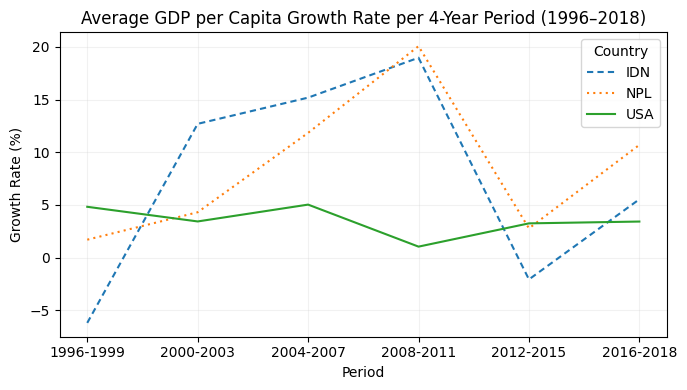

In [15]:
# Mapping dash style per country
dash_styles = {
    'USA': (None, None),   # line
    'IDN': (3, 2),   # dash
    'NPL': (1, 2)    # dot
}

# Set figure size
plt.figure(figsize=(7,4))

# Plot line for average 4-year GDP per capita growth
sns.lineplot(
    data=avg_growth_4yr,
    x='Period_4yr',
    y='GDP_PCAP_GROWTH',
    hue='Country_Code',
    style='Country_Code',
    dashes=dash_styles,
    # marker='o'
)

# Set title and labels
plt.title('Average GDP per Capita Growth Rate per 4-Year Period (1996–2018)')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Period')

# Rotate x-axis labels if needed
# plt.xticks(rotation=45)

# Light grid
plt.grid(True, color='lightgray', linewidth=0.8, alpha=0.3)

# Legend
plt.legend(title='Country', loc='best')

# Layout adjustment
plt.tight_layout()
plt.show()


# Part 3: Growth Changes in a Specific Country

In this section, the United States serves as the subject of analysis. We have imported new data covering an extended range of years, sourced from the World Development Indicators. The dataset includes the following variables:
- `Year`
- `NY_GDP_PCAP_CD` → GDP per capita
- `SH_MED_BEDS_ZS` → Hospital beds (per 1,000 people)
- `SP_POP_TOTL` → Total population

For the purposes of this section, however, we use only Year and NY_GDP_PCAP_CD.

## 3.1 Library Import and Data Preparation

In [16]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [17]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/1qqNPGa8h22rh0aamRKSlqtKJsf3oiP3Pg_3SeAPn_2A/edit?gid=1510520920#gid=1510520920"    # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df_usa = pd.read_csv(csv_export_url)                                                                                                    # Load the data into a DataFrame
df_usa.head()

,Year,NY_GDP_PCAP_CD,SH_MED_BEDS_ZS,SP_POP_TOTL
0,1974,7225.691,7.1,214000000.0
1,1975,7801.457,6.8,216000000.0
2,1976,8592.254,6.6,218000000.0
3,1977,9452.577,6.4,220000000.0
4,1978,10564.950,6.2,223000000.0


In [18]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            50 non-null     int64  
 1   NY_GDP_PCAP_CD  50 non-null     float64
 2   SH_MED_BEDS_ZS  47 non-null     float64
 3   SP_POP_TOTL     50 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.7 KB


## 3.2 Calculate Growth Rates

### 3.2.1 GDP per Head and its Annual Growth Rate

In [19]:
# Calculate annual GDP per capita growth for USA
df_usa['GDP_PCAP_GROWTH'] = df_usa['NY_GDP_PCAP_CD'].pct_change() * 100  # in percent

# Display the first few rows
df_usa.head()


,Year,NY_GDP_PCAP_CD,SH_MED_BEDS_ZS,SP_POP_TOTL,GDP_PCAP_GROWTH
0,1974,7225.691,7.1,214000000.0,NaN
1,1975,7801.457,6.8,216000000.0,7.968317
2,1976,8592.254,6.6,218000000.0,10.136530
3,1977,9452.577,6.4,220000000.0,10.012774
4,1978,10564.950,6.2,223000000.0,11.767934


In [20]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             50 non-null     int64  
 1   NY_GDP_PCAP_CD   50 non-null     float64
 2   SH_MED_BEDS_ZS   47 non-null     float64
 3   SP_POP_TOTL      50 non-null     float64
 4   GDP_PCAP_GROWTH  49 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.1 KB


### 3.2.2 GDP per Head Growth Rates per Period

In [21]:
# Copy df
df_period = df_usa.copy()

# Create a "Period" column (4-year bins)
df_period['Period'] = ((df_period['Year'] - df_period['Year'].min()) // 4) + 1

# Average growth per 4-year period
df_avg = (
    df_period.groupby('Period', as_index=False)
    .agg({
        'GDP_PCAP_GROWTH': 'mean',
        'Year': ['min', 'max']  # to label periods
    })
)

# Flatten MultiIndex columns
df_avg.columns = ['Period', 'GDP_PCAP_GROWTH', 'Year_start', 'Year_end']

# Create a label for plotting
df_avg['Label'] = df_avg['Year_start'].astype(str) + '-' + df_avg['Year_end'].astype(str)

df_avg


,Period,GDP_PCAP_GROWTH,Year_start,Year_end,Label
0,1,9.372540,1974,1977,1974-1977
1,2,10.281379,1978,1981,1978-1981
2,3,6.907313,1982,1985,1982-1985
3,4,5.812697,1986,1989,1986-1989
4,5,3.661077,1990,1993,1990-1993
5,6,4.494691,1994,1997,1994-1997
6,7,4.240050,1998,2001,1998-2001
7,8,4.415513,2002,2005,2002-2005
8,9,1.740971,2006,2009,2006-2009
9,10,3.086859,2010,2013,2010-2013


## 3.3 Visualize Growth

### 3.3.1 GDP per Head and Its Growth Rate

<Figure size 1000x500 with 0 Axes>

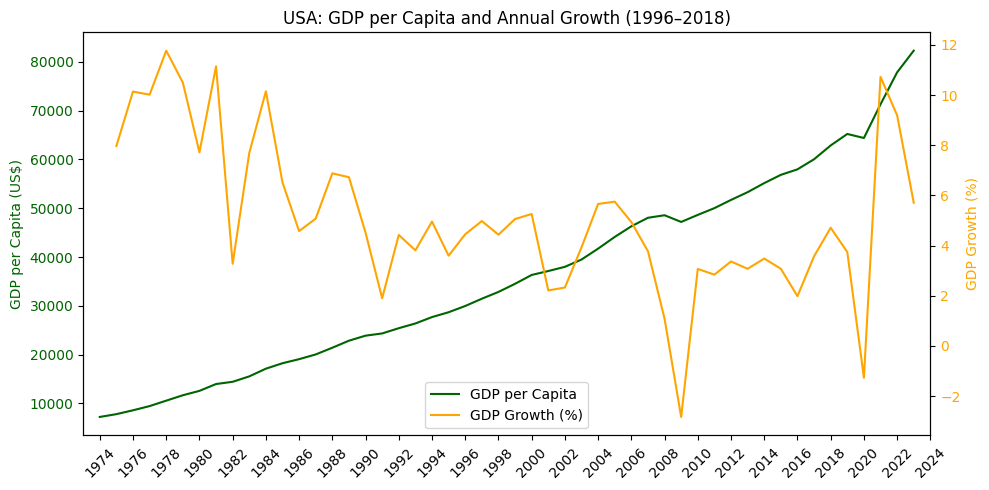

In [22]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10,5))

# Axes untuk GDP per capita (kiri)
fig, ax1 = plt.subplots(figsize=(10,5))

color_gdp = 'darkgreen'
color_growth = 'orange'

# Plot GDP per capita dengan dash line
ax1.plot(df_usa['Year'], df_usa['NY_GDP_PCAP_CD'],
         linestyle=None, color=color_gdp, marker=None, label='GDP per Capita')
ax1.set_xlabel('')
ax1.set_ylabel('GDP per Capita (US$)', color=color_gdp)
ax1.tick_params(axis='y', labelcolor=color_gdp)

# Set x-axis range and ticks
ax1.set_xlim(df_usa['Year'].min()-1, df_usa['Year'].max()+1)
ax1.set_xticks(range(df_usa['Year'].min(), df_usa['Year'].max()+2, 2))
ax1.set_xticklabels(range(df_usa['Year'].min(), df_usa['Year'].max()+2, 2), rotation=45)

# Axes untuk GDP growth (kanan)
ax2 = ax1.twinx()
ax2.plot(df_usa['Year'], df_usa['GDP_PCAP_GROWTH'],
         linestyle=None, color=color_growth, marker=None, label='GDP Growth (%)')
ax2.set_ylabel('GDP Growth (%)', color=color_growth)
ax2.tick_params(axis='y', labelcolor=color_growth)

# Title and grid
plt.title('USA: GDP per Capita and Annual Growth (1996–2018)')
ax1.grid(False)
# ax1.grid(True, color='lightgray', linewidth=0.8, alpha=0.3)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center')

plt.tight_layout()
plt.show()


### 3.3.2 GDP per Head Growth History

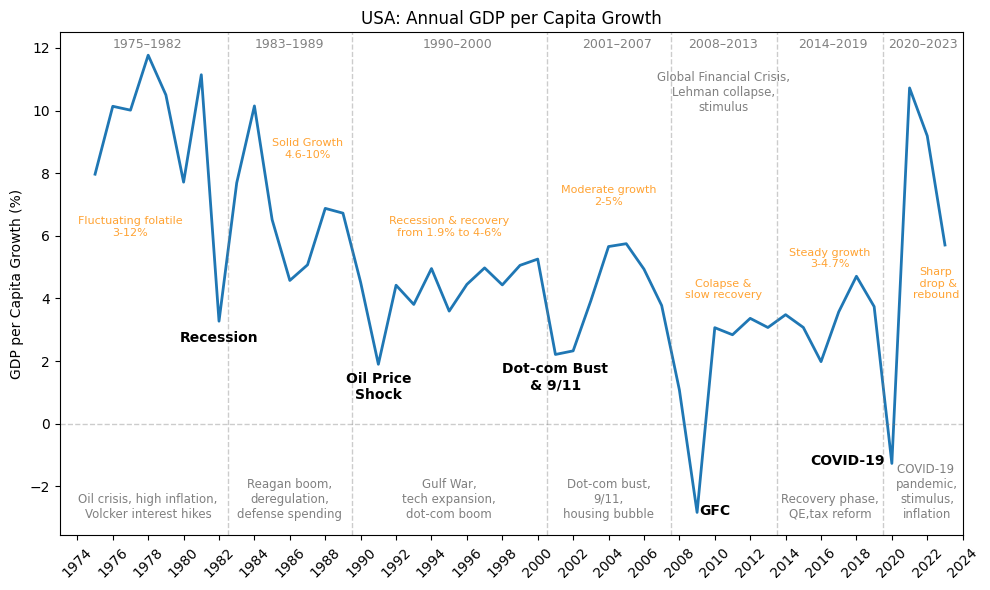

In [23]:
# Create figure and single axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot GDP per capita growth (single y-axis)
ax.plot(
    df_usa['Year'], df_usa['GDP_PCAP_GROWTH'],
    linewidth=2, label='GDP per Capita Growth (%)'
)

# Light grid for readability
# ax.grid(True, linestyle='--', alpha=0.3)

# Axis labels and title
ax.set_xlabel('')
ax.set_ylabel('GDP per Capita Growth (%)')
ax.set_title('USA: Annual GDP per Capita Growth')

# Add horizontal line at y=0
ax.axhline(y=0, linestyle='--', linewidth=1, color='gray', alpha=0.4)

# X-axis range and ticks (every 2 years, rotated)
xmin, xmax = df_usa['Year'].min(), df_usa['Year'].max()
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_xticks(range(xmin, xmax + 2, 2))
ax.set_xticklabels(range(xmin, xmax + 2, 2), rotation=45)

# Vertical dashed lines for period boundaries (subtle style)
period_bounds = [1982.5, 1989.5, 2000.5, 2007.5, 2013.5, 2019.5]
for xb in period_bounds:
    ax.axvline(x=xb, linestyle='--', linewidth=1, color='gray', alpha=0.4)

# Add period annotations
ax.text(1976, 12, "1975–1982", fontsize=9, color="gray")
ax.text(1984, 12, "1983–1989", fontsize=9, color="gray")
ax.text(1993.5, 12, "1990–2000", fontsize=9, color="gray")
ax.text(2002.5, 12, "2001–2007", fontsize=9, color="gray")
ax.text(2008.5, 12, "2008–2013", fontsize=9, color="gray")
ax.text(2014.7, 12, "2014–2019", fontsize=9, color="gray")
ax.text(2019.8, 12, "2020–2023", fontsize=9, color="gray")

# Add annotations for key events
ax.text(1978, -3, "Oil crisis, high inflation,\nVolcker interest hikes",
        fontsize=8.5, color="gray", ha="center")
ax.text(1986, -3, "Reagan boom,\nderegulation,\ndefense spending",
        fontsize=8.5, color="gray", ha="center")
ax.text(1995, -3, "Gulf War,\ntech expansion,\ndot-com boom",
        fontsize=8.5, color="gray", ha="center")
ax.text(2004, -3, "Dot-com bust,\n9/11,\nhousing bubble",
        fontsize=8.5, color="gray", ha="center")
ax.text(2010.5, 10, "Global Financial Crisis,\nLehman collapse,\nstimulus",
        fontsize=8.5, color="gray", ha="center")
ax.text(2016.5, -3, "Recovery phase,\nQE,tax reform",
        fontsize=8.5, color="gray", ha="center")
ax.text(2022, -3, "COVID-19 \npandemic,\nstimulus,\ninflation",
        fontsize=8.5, color="gray", ha="center")

# Add annotations for average growth
ax.text(1977, 6, "Fluctuating folatile\n3-12%", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(1987,   8.5, "Solid Growth\n4.6-10%", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(1995,   6, "Recession & recovery\nfrom 1.9% to 4-6%", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(2004,   7, "Moderate growth\n2-5%", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(2010.5, 4, "Colapse &\nslow recovery", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(2016.5,   5, "Steady growth\n3-4.7%", fontsize=8, color="darkorange", ha="center", alpha=0.8)
ax.text(2022.5, 4, "Sharp\n drop &\nrebound", fontsize=8, color="darkorange", ha="center", alpha=0.8)

# Add special annotation
ax.text(2010, -3, "GFC", fontsize=10, color="black", fontweight="bold",
        ha="center", va="bottom")
ax.text(1991, 0.7, "Oil Price\nShock", fontsize=10, color="black", fontweight="bold",
        ha="center", va="bottom")
ax.text(1982, 2.5, "Recession", fontsize=10, color="black", fontweight="bold",
        ha="center", va="bottom")
ax.text(2001, 1, "Dot-com Bust\n& 9/11", fontsize=10, color="black", fontweight="bold",
        ha="center", va="bottom")
ax.text(2017.5, -1.4, "COVID-19", fontsize=10, color="black", fontweight="bold",
        ha="center", va="bottom")

# Legend
# ax.legend(loc='lower center')

plt.tight_layout()
plt.show()


### 3.3.3 GDP per Head Growth Rate per Period

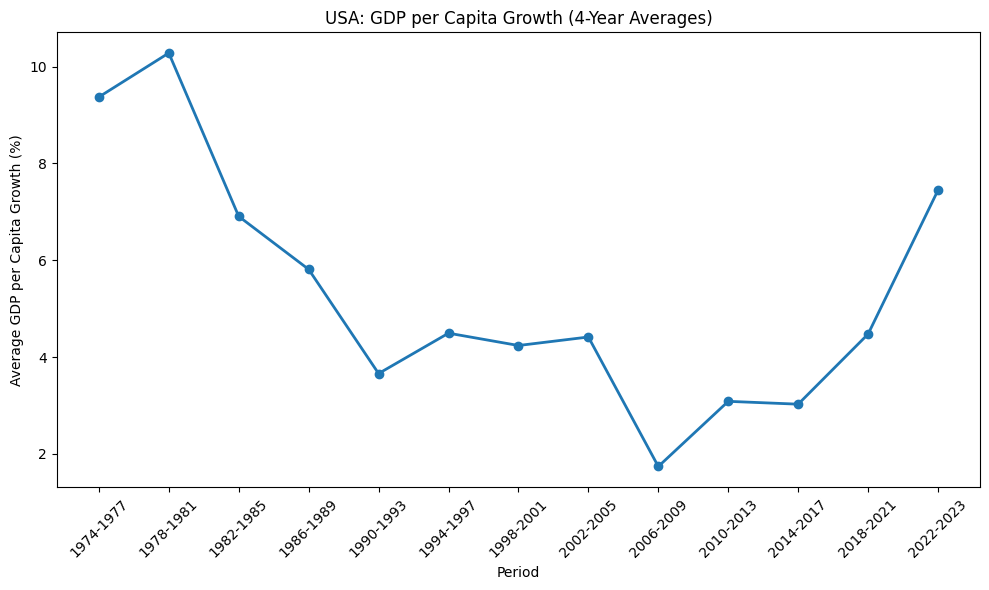

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_avg['Label'], df_avg['GDP_PCAP_GROWTH'], marker='o', linewidth=2)

ax.set_title("USA: GDP per Capita Growth (4-Year Averages)")
ax.set_xlabel("Period")
ax.set_ylabel("Average GDP per Capita Growth (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Part 4: Determinants of Growth

In this fourth section, we attempt to examine two factors that we predict influence GDP growth, particularly in OECD countries. For this purpose, we downloaded three variables from https://oecd.org, namely:
1. Growth rates of annual GDP, 1996–2023.
2. Gross fixed capital formation (index) by assets, 1995–2023.
3. Number of population aged 15–64, 1991–2019.

We chose 1996 as the starting year for GDP growth rates because only from this year onward were complete data available for all 38 OECD members. Similarly, for GFCF, complete data only became available in 1995. Since the GFCF values are in the form of an index, we manually calculated the annual growth rates for 1996–2023.

As for the population aged 15–64 (the workforce), we assume that it has a lagged effect on GDP. This is because around 50 percent of the population aged 15 typically go to university first, while the other 50 percent enter the labor market but with minimal skills. Therefore, we set 1991 as the starting year and calculated its annual growth, resulting in workforce growth data for 1992–2019.

Finally, our data structure is as follows:
- `Country_Name` → OECD member countries
- `Country_Code` → Country codes
- `GDP_GFCF_YEAR` → Years of GDP and GFCF growth data, 1996–2023
- `WF_YEAR` → Years of workforce data, 1992–2019
- `GFCF_GRWT` → Annual GFCF growth
- `WF_GRWT` → Annual Workforce growth
- `GDP_GRWT` → Annual GDP growth

## 4.1 Library Imports and Data Preparation

In [25]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Reading the dataset from Sheet1
sheet_url = "https://docs.google.com/spreadsheets/d/1qqNPGa8h22rh0aamRKSlqtKJsf3oiP3Pg_3SeAPn_2A/edit?gid=1712883783#gid=1712883783"    # Paste your data link here
csv_export_url = sheet_url.replace("/edit?gid=", "/export?format=csv&gid=")                                                             # Convert the link to a CSV format readable in Google Colab
df_oecd = pd.read_csv(csv_export_url)                                                                                                   # Load the data into a DataFrame
df_oecd.head()

,No,Country_Name,Country_Code,GDP_GFCF_YEAR,WF_YEAR,GFCF_GRWT,WF_GRWT,GDP_GRWT
0,1,Australia,AUS,1996,1992,6.638256,1.003802,3.913247
1,2,Austria,AUT,1996,1992,3.343597,0.974671,2.215767
2,3,Belgium,BEL,1996,1992,0.553090,0.104120,1.321432
3,4,Canada,CAN,1996,1992,5.769099,0.936684,1.688961
4,5,Chile,CHL,1996,1992,8.918750,2.401743,7.413506


In [27]:
df_oecd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             1064 non-null   int64  
 1   Country_Name   1064 non-null   object 
 2   Country_Code   1064 non-null   object 
 3   GDP_GFCF_YEAR  1064 non-null   int64  
 4   WF_YEAR        1064 non-null   int64  
 5   GFCF_GRWT      1064 non-null   float64
 6   WF_GRWT        1064 non-null   float64
 7   GDP_GRWT       1064 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 66.6+ KB


## 4.2 Relationship Exploration (Latest Year)

In this section, we examine the relationship between GDP growth and GFCF growth, as well as between GDP growth and workforce growth. The analysis focuses exclusively on the most recent year, yielding 38 data points, corresponding to the number of OECD member countries.

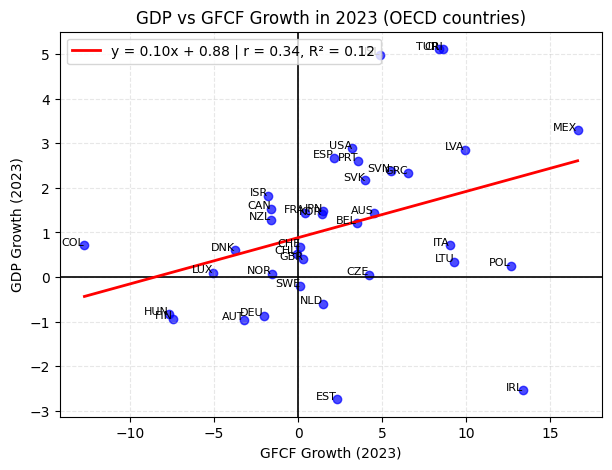

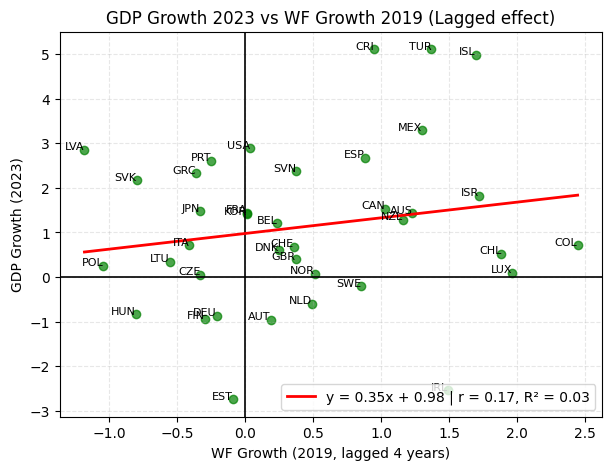

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) GDP vs GFCF in 2023 ---
gdp_2023 = df_oecd[df_oecd['GDP_GFCF_YEAR'] == 2023][
    ['Country_Code','Country_Name','GDP_GRWT','GFCF_GRWT']
]

plt.figure(figsize=(7,5))
plt.scatter(gdp_2023['GFCF_GRWT'], gdp_2023['GDP_GRWT'], color='blue', alpha=0.7)

# Make grid lines light and less distracting
plt.grid(True, linestyle="--", alpha=0.3)

# Add reference lines
plt.axhline(0, color="black", linewidth=1.2)   # horizontal line at y=0
plt.axvline(0, color="black", linewidth=1.2)   # vertical line at x=0

# Regression line + correlation stats
x = gdp_2023['GFCF_GRWT'].values
y = gdp_2023['GDP_GRWT'].values
mask = ~np.isnan(x) & ~np.isnan(y)
a, b = np.polyfit(x[mask], y[mask], 1)
r = np.corrcoef(x[mask], y[mask])[0,1]
r2 = r**2

xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, a*xx + b, color="red", linewidth=2,
         label=f"y = {a:.2f}x + {b:.2f} | r = {r:.2f}, R² = {r2:.2f}")

plt.xlabel("GFCF Growth (2023)")
plt.ylabel("GDP Growth (2023)")
plt.title("GDP vs GFCF Growth in 2023 (OECD countries)")

# Add country code labels to points
for _, row in gdp_2023.iterrows():
    plt.text(row['GFCF_GRWT'], row['GDP_GRWT'], row['Country_Code'], fontsize=8, ha='right')

plt.legend()
plt.show()
print()


# --- 2) GDP 2023 vs WF (lagged from 2019) ---
gdp_2023 = df_oecd[df_oecd['GDP_GFCF_YEAR'] == 2023][
    ['Country_Code','Country_Name','GDP_GRWT']
]
wf_2019  = df_oecd[df_oecd['WF_YEAR'] == 2019][
    ['Country_Code','WF_GRWT']
]

# Merge GDP 2023 with WF 2019 (lag effect)
merged = gdp_2023.merge(wf_2019, on="Country_Code", how="inner")

plt.figure(figsize=(7,5))
plt.scatter(merged['WF_GRWT'], merged['GDP_GRWT'], color='green', alpha=0.7)

# Make grid lines light
plt.grid(True, linestyle="--", alpha=0.3)

# Add reference lines
plt.axhline(0, color="black", linewidth=1.2)   # horizontal line at y=0
plt.axvline(0, color="black", linewidth=1.2)   # vertical line at x=0

# Regression line + correlation stats
x = merged['WF_GRWT'].values
y = merged['GDP_GRWT'].values
mask = ~np.isnan(x) & ~np.isnan(y)
a, b = np.polyfit(x[mask], y[mask], 1)
r = np.corrcoef(x[mask], y[mask])[0,1]
r2 = r**2

xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, a*xx + b, color="red", linewidth=2,
         label=f"y = {a:.2f}x + {b:.2f} | r = {r:.2f}, R² = {r2:.2f}")

plt.xlabel("WF Growth (2019, lagged 4 years)")
plt.ylabel("GDP Growth (2023)")
plt.title("GDP Growth 2023 vs WF Growth 2019 (Lagged effect)")

# Add country code labels
for _, row in merged.iterrows():
    plt.text(row['WF_GRWT'], row['GDP_GRWT'], row['Country_Code'], fontsize=8, ha='right')

plt.legend()
plt.show()


## 4.3 Relationship Exploration (Pooled)

In this section, we explore the relationship between GDP growth and GFCF growth, as well as between GDP growth and workforce growth, using a slightly different technique from that in Section 4.2. Specifically, we plot all cross-year data from OECD member countries in a pooled scatterplot, which allows the relationship to be observed more clearly over the long term.

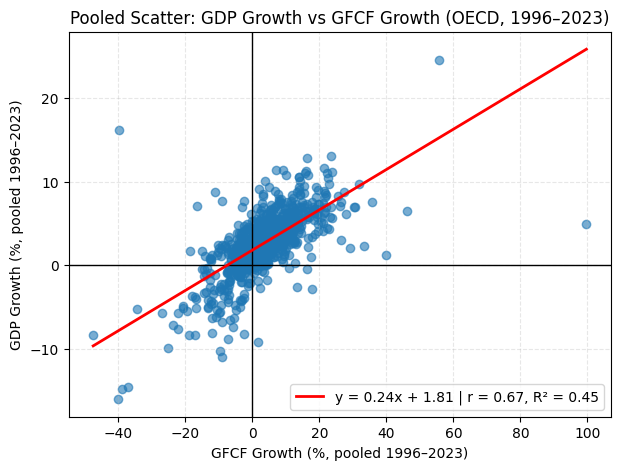

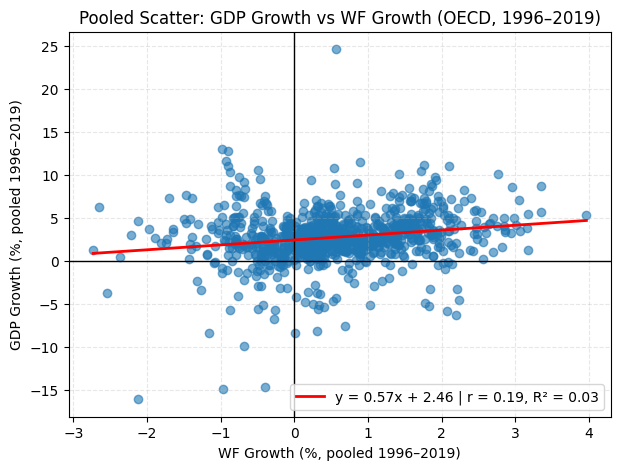

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# A) GDP_GRWT (y) vs GFCF_GRWT (x), pooled 1996–2023
# ---------------------------
gdp_gfcf = df_oecd[
    (df_oecd['GDP_GFCF_YEAR'] >= 1996) & (df_oecd['GDP_GFCF_YEAR'] <= 2023)
][['Country_Code', 'Country_Name', 'GDP_GFCF_YEAR', 'GDP_GRWT', 'GFCF_GRWT']].copy()

gdp_gfcf = gdp_gfcf.dropna(subset=['GDP_GRWT', 'GFCF_GRWT'])

plt.figure(figsize=(7,5))
plt.scatter(gdp_gfcf['GFCF_GRWT'], gdp_gfcf['GDP_GRWT'], alpha=0.6)

# Light grid + reference lines
plt.grid(True, linestyle="--", alpha=0.3)
plt.axhline(0, color="black", linewidth=1.0)
plt.axvline(0, color="black", linewidth=1.0)

# Regression trendline
x = gdp_gfcf['GFCF_GRWT'].values
y = gdp_gfcf['GDP_GRWT'].values
mask = ~np.isnan(x) & ~np.isnan(y)
a, b = np.polyfit(x[mask], y[mask], 1)
r = np.corrcoef(x[mask], y[mask])[0,1]
r2 = r**2

xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, a*xx + b, color="red", linewidth=2,
         label=f"y = {a:.2f}x + {b:.2f} | r = {r:.2f}, R² = {r2:.2f}")

plt.xlabel("GFCF Growth (%, pooled 1996–2023)")
plt.ylabel("GDP Growth (%, pooled 1996–2023)")
plt.title("Pooled Scatter: GDP Growth vs GFCF Growth (OECD, 1996–2023)")
plt.legend()
plt.show()
print()

# ---------------------------
# B) GDP_GRWT (y) vs WF_GRWT (x), pooled 1996–2019
# ---------------------------
gdp = df_oecd[['Country_Code', 'Country_Name', 'GDP_GFCF_YEAR', 'GDP_GRWT']].rename(
    columns={'GDP_GFCF_YEAR': 'Year'}
)
wf  = df_oecd[['Country_Code', 'WF_YEAR', 'WF_GRWT']].rename(
    columns={'WF_YEAR': 'Year'}
)

gdp_wf = (gdp.merge(wf, on=['Country_Code', 'Year'], how='inner')
             .query('Year >= 1996 and Year <= 2019')
             .dropna(subset=['GDP_GRWT', 'WF_GRWT'])
             .copy())

plt.figure(figsize=(7,5))
plt.scatter(gdp_wf['WF_GRWT'], gdp_wf['GDP_GRWT'], alpha=0.6)

# Light grid + reference lines
plt.grid(True, linestyle="--", alpha=0.3)
plt.axhline(0, color="black", linewidth=1.0)
plt.axvline(0, color="black", linewidth=1.0)

# Regression trendline
x = gdp_wf['WF_GRWT'].values
y = gdp_wf['GDP_GRWT'].values
mask = ~np.isnan(x) & ~np.isnan(y)
a, b = np.polyfit(x[mask], y[mask], 1)
r = np.corrcoef(x[mask], y[mask])[0,1]
r2 = r**2

xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, a*xx + b, color="red", linewidth=2,
         label=f"y = {a:.2f}x + {b:.2f} | r = {r:.2f}, R² = {r2:.2f}")

plt.xlabel("WF Growth (%, pooled 1996–2019)")
plt.ylabel("GDP Growth (%, pooled 1996–2019)")
plt.title("Pooled Scatter: GDP Growth vs WF Growth (OECD, 1996–2019)")
plt.legend()
plt.show()


## 4.4 Repeated Cross-Section Regression

### 4.4.1 GDP Growth and GFCF Growth

In [30]:
results_gfcf = []

# Loop over each year
for year in sorted(df_oecd['GDP_GFCF_YEAR'].unique()):
    data_year = df_oecd[df_oecd['GDP_GFCF_YEAR'] == year][['GDP_GRWT', 'GFCF_GRWT']].dropna()

    if len(data_year) > 5:  # require some observations to run regression
        X = sm.add_constant(data_year['GFCF_GRWT'])  # adds intercept
        y = data_year['GDP_GRWT']

        model = sm.OLS(y, X).fit()

        beta0 = model.params['const']
        beta1 = model.params['GFCF_GRWT']
        p_beta1 = model.pvalues['GFCF_GRWT']
        r2 = model.rsquared

        # Categorize significance at 5% level
        sig_category = "p < 0.05" if p_beta1 < 0.05 else "p ≥ 0.05"

        results_gfcf.append({
            'Year': year,
            'beta0': beta0,
            'beta1': beta1,
            'p_beta1': p_beta1,
            'r2': r2,
            'significance': sig_category
        })

# Convert to DataFrame
regression_gfcf_df = pd.DataFrame(results_gfcf)

# Show first rows
regression_gfcf_df


,Year,beta0,beta1,p_beta1,r2,significance
0,1996,2.228216,0.146322,9.801461e-05,0.347665,p < 0.05
1,1997,2.779371,0.245989,1.177385e-06,0.485519,p < 0.05
2,1998,2.326613,0.166428,1.408269e-07,0.541510,p < 0.05
3,1999,2.614029,0.257801,9.901408e-11,0.691766,p < 0.05
4,2000,3.878200,0.170886,1.157280e-04,0.341884,p < 0.05
5,2001,1.963479,0.243485,1.104401e-10,0.689911,p < 0.05
6,2002,2.340345,0.214483,1.514105e-05,0.409590,p < 0.05
7,2003,1.547635,0.306935,1.577337e-08,0.593076,p < 0.05
8,2004,2.742822,0.218565,3.055845e-10,0.672094,p < 0.05
9,2005,2.209470,0.238007,4.692156e-08,0.568142,p < 0.05


### 4.4.2 GDP Growth and Workforce Growth

In [31]:
results_wf = []

# Loop over each year
for year in sorted(df_oecd['GDP_GFCF_YEAR'].unique()):
    data_year = df_oecd[df_oecd['GDP_GFCF_YEAR'] == year][['GDP_GRWT', 'WF_GRWT']].dropna()

    if len(data_year) > 5:  # require some observations to run regression
        X = sm.add_constant(data_year['WF_GRWT'])  # adds intercept
        y = data_year['GDP_GRWT']

        model = sm.OLS(y, X).fit()

        beta0 = model.params['const']
        beta1 = model.params['WF_GRWT']
        p_beta1 = model.pvalues['WF_GRWT']
        r2 = model.rsquared

        # Categorize significance at 5% level
        sig_category = "p < 0.05" if p_beta1 < 0.05 else "p ≥ 0.05"

        results_wf.append({
            'Year': year,
            'beta0': beta0,
            'beta1': beta1,
            'p_beta1': p_beta1,
            'r2': r2,
            'significance': sig_category
        })

# Convert to DataFrame
regression_wf_df = pd.DataFrame(results_wf)

# Show first rows
regression_wf_df


,Year,beta0,beta1,p_beta1,r2,significance
0,1996,2.992459,0.595671,0.054823,0.098639,p ≥ 0.05
1,1997,5.197384,-0.602051,0.132655,0.061698,p ≥ 0.05
2,1998,3.713134,-0.023242,0.955272,0.000089,p ≥ 0.05
3,1999,2.886895,0.331613,0.523438,0.011401,p ≥ 0.05
4,2000,4.538762,0.136587,0.703427,0.004074,p ≥ 0.05
5,2001,3.011329,-0.695703,0.064342,0.091870,p ≥ 0.05
6,2002,2.814360,-0.148180,0.742618,0.003033,p ≥ 0.05
7,2003,3.039598,-0.132567,0.789386,0.002008,p ≥ 0.05
8,2004,3.685534,0.747810,0.033536,0.119479,p < 0.05
9,2005,3.940427,-0.024788,0.958312,0.000077,p ≥ 0.05


4.4.3 Plots of Beta1 across Years (GFCF and Workforcce Growth)

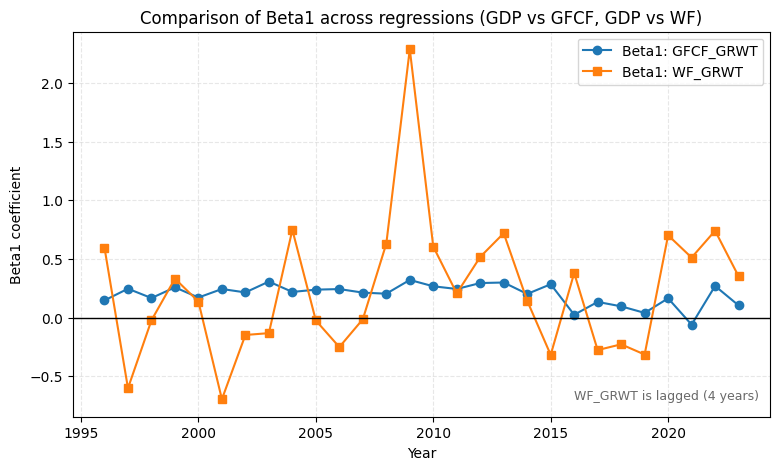

In [32]:
plt.figure(figsize=(9,5))

# Plot beta1 from GDP~GFCF
plt.plot(regression_gfcf_df['Year'], regression_gfcf_df['beta1'],
         marker='o', label='Beta1: GFCF_GRWT')

# Plot beta1 from GDP~WF (lagged)
plt.plot(regression_wf_df['Year'], regression_wf_df['beta1'],
         marker='s', label='Beta1: WF_GRWT')

# Add reference line at 0
plt.axhline(0, color="black", linewidth=1)

# Grid
plt.grid(True, linestyle="--", alpha=0.3)

plt.xlabel("Year")
plt.ylabel("Beta1 coefficient")
plt.title("Comparison of Beta1 across regressions (GDP vs GFCF, GDP vs WF)")
plt.legend()

# Optional: add annotation inside plot
plt.annotate("WF_GRWT is lagged (4 years)",
             xy=(regression_wf_df['Year'].max()-7,
                 regression_wf_df['beta1'].min()),
             xycoords="data", fontsize=9, color="dimgray")

plt.show()
